# Lab 12 – Hyperparameter tuning

DUE: April 8, 2024 (Wed)  
Pair Programming: Optional, but highly encouraged  
Name(s): Harrison Halesworth 
Class: CSCI 349 - Intro to Data Mining  
Section: 01-11am
Semester: Spring 2024  
Instructors: Brian King, Joshua Stough  

# Objectives

This lab will introduce the student to understanding **hyperparameter tuning**. Specifically, the objectives are as follows:

- Understand the impact of hyperparameters with model induction and performance
- Learn to use the `GridSearchCV` class to find good parameters for your model

--- 
# Background
You were introduced to Keras deep learning framework in the last lab. You also learned how to use the Keras wrapper class, `KerasClassifier`, so that you could continue to use the wonderful **scikit-learn** framework for data mining and machine learning, leveraging Keras within the environment you know. You also learned that there are an enormous number of parameters to consider to get a good result! Yeah, you could do it manually by creating multiple loops to evaluate different model parameters (and lose all your hair... maybe that was it) or you could use scikit-learn's framework to do this.

## What is hyperparameter tuning
The real focus of this lab is to learn how to use the **scikit-learn** framework to assist you with hyperparameter tuning.  Every machine learning model has parameters that control model induction. They are generally referred to hyperparamters, and you need to optimize them for your given problem. The parameters usually come down to figuring out how to control the complexity of your model such that it is able to learn from your data, but not overfit. (Recall our bias vs. variance tradeoff discussion!) Understanding this is critical. Understanding how to address it is even better, and is an important skill to learn. You will in this lab.

Generally, there are two approaches you can take to hyperparameter tuning. You could write an enormous number of loops yourself to track the model parameters you are experimenting with and keep track of the model performances coming from each parameter set. Or, you can use a grid search framework to search for the parameters. That's the purpose of scikit-learn's `GridSearchCV` class.

>WARNING: Hyperparameter tuning can use a LOT of computational resources, both CPU and memory! Depending on how you set up your test, and the complexity of the model being evaluated, you could be waiting days for a result! So, ALWAYS start with a simple setup (small data sample, limited number of parameters to test) before you run an exhaustive grid search for your optimal parameters!

## Preparing for this lab

Some of this lab is modeled after some code given in a few different web sites, and you might get more out of the lab by taking a few minutes to skim through these pages, just to understand the framework you are going to be using to perform a grid-search for optimal hyperparameters. You might even want to just keep these pages open in your browser.

- First, the most important page you'll need is the reference to GridSearchCV: 
    - [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
- The best example code can be found right on the scikit-learn site:
    - [https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html](https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html)
- The user guide has an exhaustive writeup covering the topic of hyper-parameter tuning. This has a *lot* of good information, some of which is far more advanced than anything you need at this time:
    - [https://scikit-learn.org/stable/modules/grid_search.html](https://scikit-learn.org/stable/modules/grid_search.html)
- The following page illustrates a bit simpler code to get you started, however, note that it uses the `Sequential` model, vs. using the *Functional API*:
    - [https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/](https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/).

That's it!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Dense, Activation
from keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from keras.activations import relu, tanh

In [2]:
print(tf.__version__)

2.10.0


In [3]:
print(keras.__version__)

2.10.0


***
# The classic Wine dataset
There have been *many* datasets appearing over the past 15 years or so that attempt to try and capture numerous objective measures to characterize wine. An often-used dataset for classification exercises is the infamous wine dataset from the early 1990s. Not quite as popular as iris, but pretty close. It's a bit more complex than iris, with 13 variables and 1 target multi-class variable. As far as I know, there is no model that has obtained near 100% accuracy on validation. However, we can usually get in the mid 90s on the best models.

### Reading in the wine data

Open the following page:
* [https://archive.ics.uci.edu/ml/datasets/wine](https://archive.ics.uci.edu/ml/datasets/wine)

This page will give you the data and the information you need to start this lab.  (If you prefer, it is also one of the built-in datasets available in `sklearn.datasets` package (see [https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) ). Either way, you need to first convert this to a pandas data frame.

The following snippet of code will read in the data directly from the UCI machine learning site, as a data frame in its raw form:

```
names = ["target","alcohol","malic_acid","ash","alcalinity","Mg","tot_phenols","flavanoids",
         "non_flav_phenols","proanthocyanins","color_intensity",
         "hue","OD","proline"]

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None,names=names)
```

This is the first lab that is provided as an unanswered .ipynb file to help you focus on the work and not get caught up in dealing with formatting. You've got the formatting down, so focus on really absorbing this material. This is using some advanced techniques that anyone who actually works in this field will want to know fluently and be ready to discuss. This lab is a culminating experience that represents the type of analyses you will do if you do this type of work in "the real world." And likewise, this is a bit more "hands off" than the previous lab was. On the bright side, I chose a dataset that has  many, many published examples already that demonstrate reading and modeling these exact data.

>NOTE: As usual, with all of the popular datasets, there are many examples available online that can help you understand the data, clean the data, generate EDA plots to understand the distributions, etc. I encourage you to search for code to generate some reasonable plots with these data! (And, include all URLs that you use!)

***
**1)** Read in the wine data frame using the code given above. It also gives you the names of the variables, which should be the same as the data information given on the UCI web page. Store your result as `df_wine`.

In [4]:
names = ["target","alcohol","malic_acid","ash","alcalinity","Mg","tot_phenols","flavanoids",
         "non_flav_phenols","proanthocyanins","color_intensity",
         "hue","OD","proline"]

df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data',header=None,names=names)
df_wine.head()

,target,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


***
**2)** Prepare your data. Over multiple code cells, minimally, you should be reporting:
- `shape`, `info()`, etc
- Cast the type of each variables into its most correct type, paying special attention to the target class (which is coincidentally called `target`, and should be a categorical variable). Fortunately, these are already going to read in mostly correct.
- Report on any missing data. (There shouldn't be any.)
- Show the `head()` of the data frame



In [5]:
df_wine.shape

(178, 14)

In [6]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   target            178 non-null    int64  
 1   alcohol           178 non-null    float64
 2   malic_acid        178 non-null    float64
 3   ash               178 non-null    float64
 4   alcalinity        178 non-null    float64
 5   Mg                178 non-null    int64  
 6   tot_phenols       178 non-null    float64
 7   flavanoids        178 non-null    float64
 8   non_flav_phenols  178 non-null    float64
 9   proanthocyanins   178 non-null    float64
 10  color_intensity   178 non-null    float64
 11  hue               178 non-null    float64
 12  OD                178 non-null    float64
 13  proline           178 non-null    int64  
dtypes: float64(11), int64(3)
memory usage: 19.6 KB


In [7]:
df_wine["target"] = df_wine["target"].astype("category")
# columns = df_wine.columns.tolist()
# columns.remove("target")
# columns.append("target")
# df_wine = df_wine[columns]
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   target            178 non-null    category
 1   alcohol           178 non-null    float64 
 2   malic_acid        178 non-null    float64 
 3   ash               178 non-null    float64 
 4   alcalinity        178 non-null    float64 
 5   Mg                178 non-null    int64   
 6   tot_phenols       178 non-null    float64 
 7   flavanoids        178 non-null    float64 
 8   non_flav_phenols  178 non-null    float64 
 9   proanthocyanins   178 non-null    float64 
 10  color_intensity   178 non-null    float64 
 11  hue               178 non-null    float64 
 12  OD                178 non-null    float64 
 13  proline           178 non-null    int64   
dtypes: category(1), float64(11), int64(2)
memory usage: 18.5 KB


In [8]:
missing = df_wine.isnull().sum()
missing

target              0
alcohol             0
malic_acid          0
ash                 0
alcalinity          0
Mg                  0
tot_phenols         0
flavanoids          0
non_flav_phenols    0
proanthocyanins     0
color_intensity     0
hue                 0
OD                  0
proline             0
dtype: int64

In [9]:
df_wine.head()

,target,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


***
**3)**
We're going to perform the essential task of EDA. First, *numerically* (not visually or graphically) summarize your data. Minimally, you at least want to:
* Output `describe()`
* Report the table of counts of the target variable
* Show the means of each variable, grouped by target value

In [10]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [11]:
counts = df_wine["target"].value_counts()
counts

target
2    71
1    59
3    48
Name: count, dtype: int64

In [12]:
means = df_wine.groupby("target", observed=False).mean()
means

,alcohol,malic_acid,ash,alcalinity,Mg,tot_phenols,flavanoids,non_flav_phenols,proanthocyanins,color_intensity,hue,OD,proline
target,,,,,,,,,,,,,
1,13.744746,2.010678,2.455593,17.037288,106.338983,2.840169,2.982373,0.290000,1.899322,5.528305,1.062034,3.157797,1115.711864
2,12.278732,1.932676,2.244789,20.238028,94.549296,2.258873,2.080845,0.363662,1.630282,3.086620,1.056282,2.785352,519.507042
3,13.153750,3.333750,2.437083,21.416667,99.312500,1.678750,0.781458,0.447500,1.153542,7.396250,0.682708,1.683542,629.895833


***
**4)** Now, provide at least 3 plots of your own choosing to help visually and graphically understand the distributions of your variables. It's entirely up to you to choose and design the plots to convey important information about your data. Some ideas I always start with:
* A barchart of the target variable counts
* A boxplot of each numeric variable. Even better is a boxplot that uses a color (hue) for each target value
* Density or histogram (e.g. seaborn `kdeplot`) plots of each variable, colored by target. (HINT - `sns.FacetGrid` is ideal for this.)
* A pairwise correlation heatmap visualizing the variable correlations
* A Seaborn `pairplot`. (However, with 13 predictor variables and one target, this can get unweldy, not to mention it can take some time to generate it. Try it, and then determine if it'd be better to just select a subset of variables.

In [13]:
# This might be helpful?
df_wine_melt = df_wine.melt(id_vars=['target'])
df_wine_melt.head()

,target,variable,value
0,1,alcohol,14.23
1,1,alcohol,13.20
2,1,alcohol,13.16
3,1,alcohol,14.37
4,1,alcohol,13.24


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


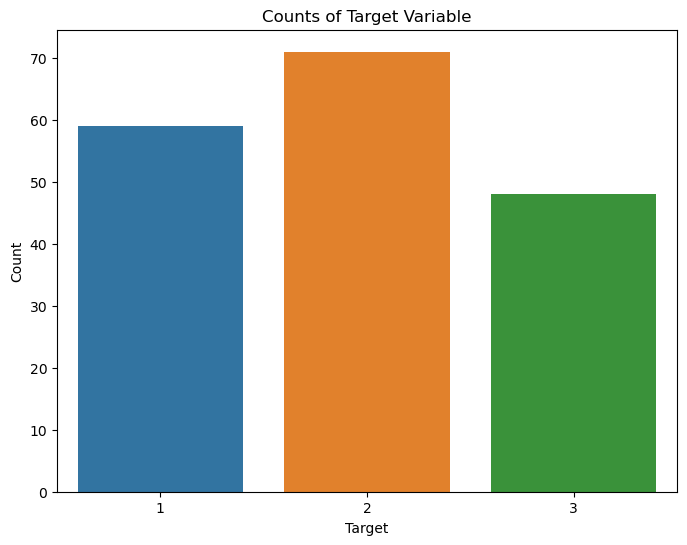

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x="target", data=df_wine)
plt.title("Counts of Target Variable")
plt.xlabel("Target")
plt.ylabel("Count")
plt.show()

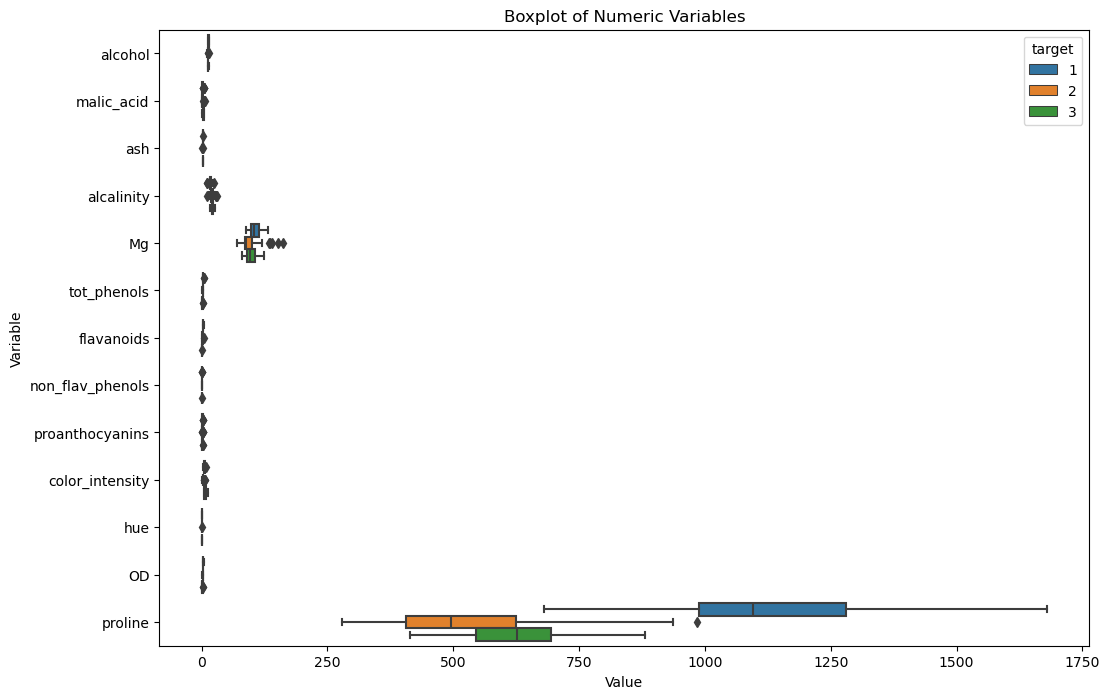

In [15]:
plt.figure(figsize=(12, 8))
sns.boxplot(x="value", y="variable", hue="target", data=df_wine_melt)
plt.title("Boxplot of Numeric Variables")
plt.xlabel("Value")
plt.ylabel("Variable")
plt.show()

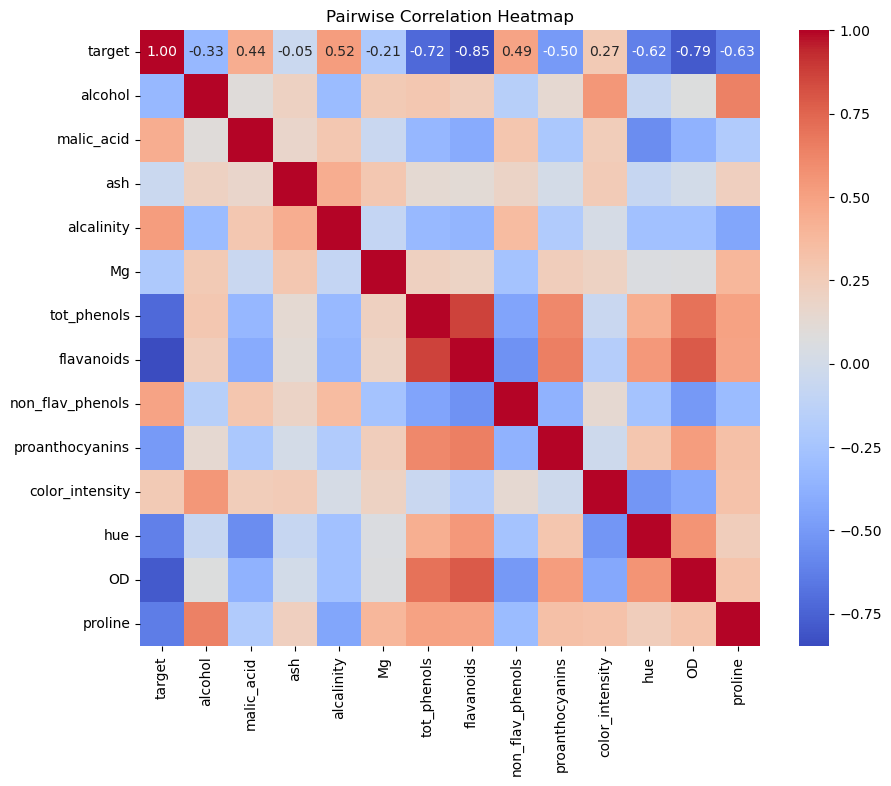

In [16]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_wine.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pairwise Correlation Heatmap")
plt.show()

**4b)** [M] Here is a heatmap. Run the cell and examine the output. Study and interpret what it's conveying.

<Axes: >

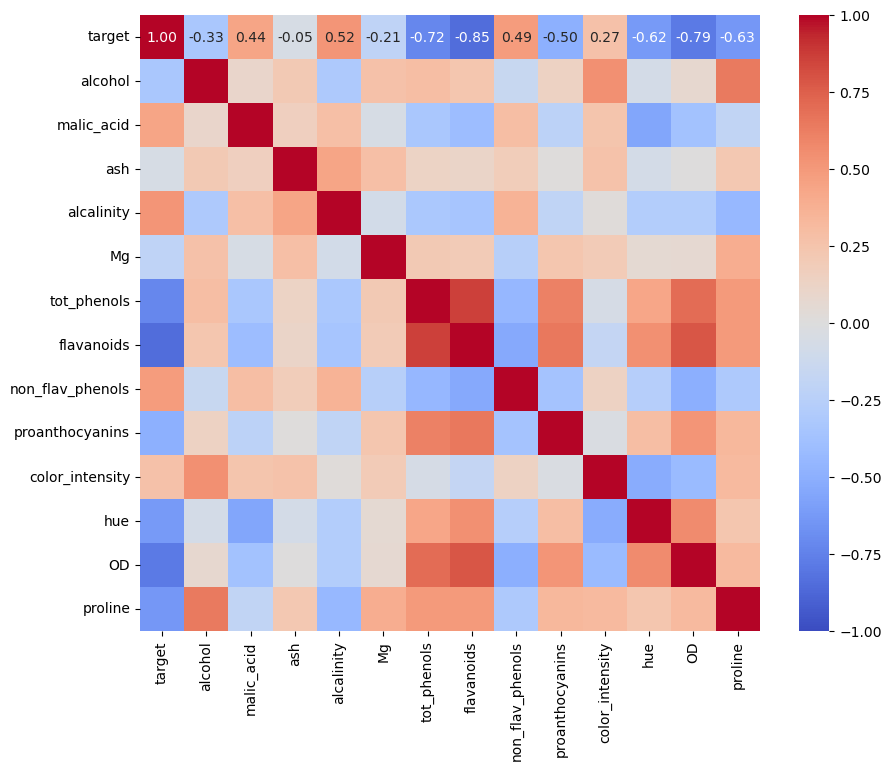

In [17]:
plt.figure(figsize=(10,8))
sns.heatmap(df_wine.corr(),
            center=0, vmin=-1, vmax=1, cmap="coolwarm",
            annot=True, fmt=".2f")

ANSWER:This heat map calculates and portrays the correlation coeffecient between each numerical variable, and so the more positively correlated variables are a warmer (more red) color and any (X, X) entry in the matrix is perfectly warm, naturally. Negatively correlated variables are depicted as cooler or more blue and anything gray indicates little correlation. There seems to be strong positive correlation between the target variable and malic_acid, alcalinity, and non_flav_phenols and strong negative correlation between the target variable and tot_phenols, flavanoids, and OD.

**4c)** [M] Look up Seaborn's clustermap function. What is this conveying? Are there similarities to the previous heatmap? (This is a bit of a taste of our last topic we will soon cover on clustering.) [https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html#seaborn.clustermap)

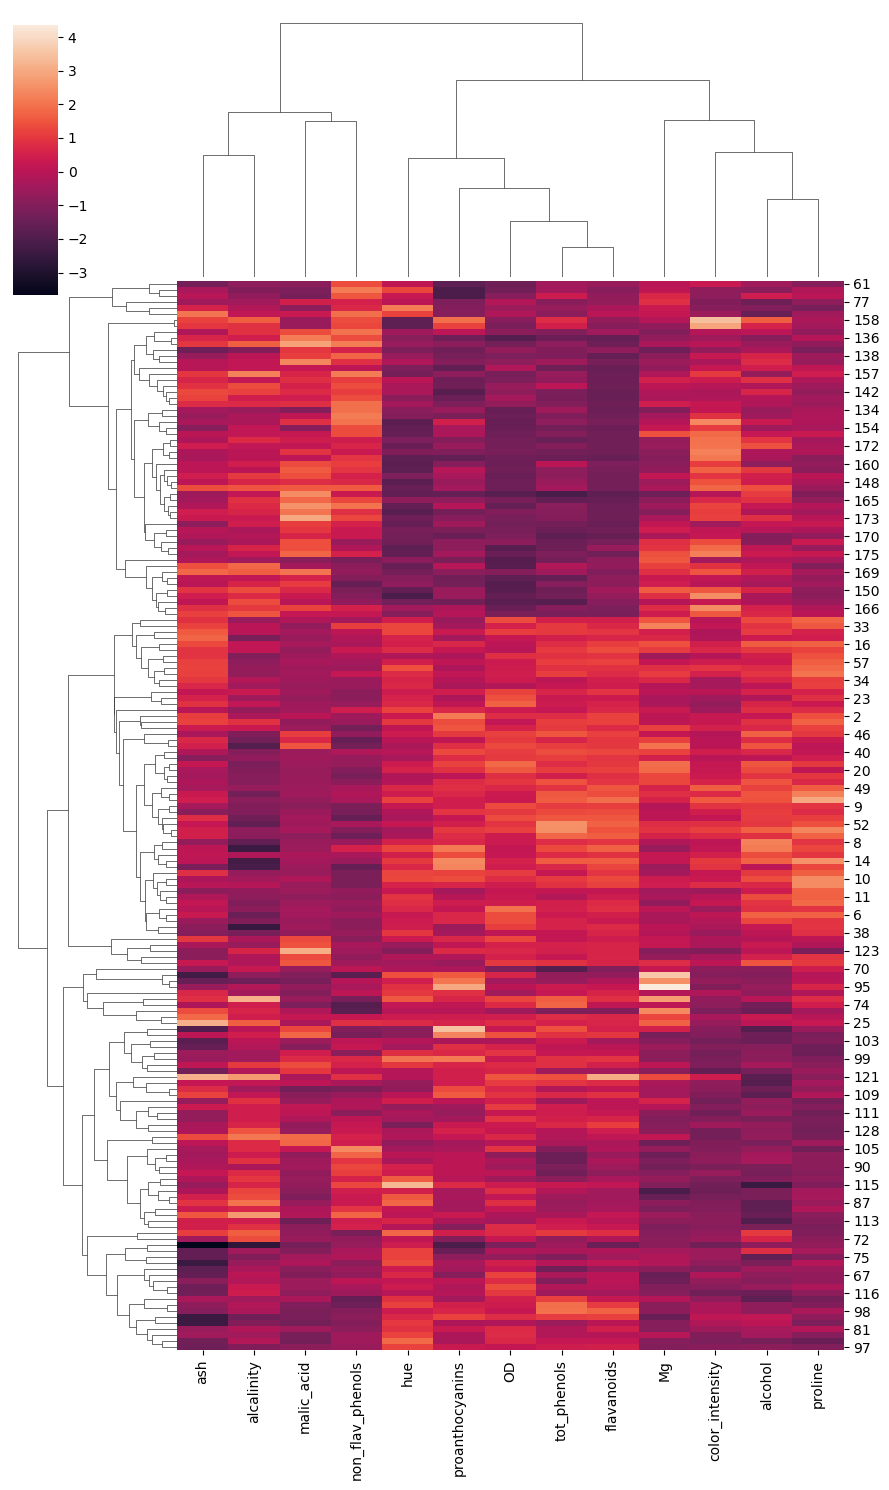

In [18]:
sns.clustermap(df_wine.iloc[:,1:],row_cluster=True,col_cluster=True,
               z_score=1,metric="correlation",
               figsize=(9,15))

ANSWER: Seaborn's clustermap function is used to create a hierarchical clustering heatmap, which arranges both rows and columns of the heatmap based on their similarity to each other. This function clusters similar rows and columns together, providing a visual representation of the relationships between variables and observations in the dataset.

The clustermap function can be particularly useful for exploring patterns and relationships within the data, especially when combined with hierarchical clustering. It allows you to identify clusters of variables or observations that have similar characteristics, which can provide insights into underlying structures or patterns in the data.

This clustermpa is similar to the heatmap in that it displays pairwise correlation with a color hue which helps visualize what variables and variable combinations are correlated.

***
**5)**	Set up your `X` and `y` data frames to prepare for your modeling steps. Be sure to normalize your `X` variables. (Use z-score transform. Any approach will do, but `StandardScaler()` keeps in you the scikit-learn world.) Be sure to create a binarized version of `y` as well, called `y_bin` or `y_ohe`. Just don't delete the original `y`. Be sure you shuffle your data.

NOTE: You'll need both types of y. Some classifiers work great on single target variables that are multi-class such as these data. However, others do not. You'll needed the binarized variable for neural nets! Remember, binarization is important for classifiers such as neural nets when you are working with a target variable that is multi-class (i.e. more than two labels). 

In [19]:
X = df_wine.drop(columns="target")
y = df_wine["target"]

scaler = StandardScaler()
X = scaler.fit_transform(X)

binarizer = LabelBinarizer()
y_bin = binarizer.fit_transform(y)

X, y, y_bin = shuffle(X, y, y_bin, random_state=42)

***

## Decision Trees

**6a)** Let's induce a basic Decision Tree Classifier (i.e. `DecisionTreeClassifier()`). Don't set any initial parameters. Let the default tree induction parameters be used. Evaluate the tree using a 5-fold cross validation. Perform a standard report of your class-wide performance metrics (i.e. using classification report, but specify 3 significant digits instead of the default of 2). You should have most of this code completed from a previous lab.

What is the overall accuracy? Which class performs the best? The worst?

In [20]:
clf = DecisionTreeClassifier()

kf = KFold(n_splits=5, shuffle=True)

true_labels = []
predicted_labels = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    true_labels.extend(y_test)
    predicted_labels.extend(y_pred)

report = classification_report(true_labels, predicted_labels, digits=3)
print(report)

              precision    recall  f1-score   support

           1      0.351     0.339     0.345        59
           2      0.423     0.423     0.423        71
           3      0.300     0.312     0.306        48

    accuracy                          0.365       178
   macro avg      0.358     0.358     0.358       178
weighted avg      0.366     0.365     0.365       178



The overall f1-score is 0.365, the best performing class was class 2 and the worst performing class was class 3.

**6b)**	Try to run your code above a few different times. Your performance results should fluctuate a bit. Why?

ANSWER: The randomization involved in the cross validation process leads to a fluctuation in results as the shuffle of data and splitting helps randomize model creation.

**6c)** For comparisons purposes, clearly print out what the value of your f1 score is using the function `f1_score` from `sklearn.metrics`. Do not copy and paste the values, but compute it using sklearn. 

In [21]:
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1 score:", f1)

F1 score: 0.3653859839170073


***
## Using GridSearchCV with Decision Trees

**7)**	As we learned, a decision tree is a pretty simple, straightforward model for classification purposes. Despite its simplicity, it has a lot of possible parameters that affect how the tree is induced. The `DecisionTreeClassifier` class offers those parameters for you to fine tune your tree induction. See [https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreeclassifier#sklearn.tree.DecisionTreeClassifier) so that you can understand the wide number of parameters you can use to influence your final model. There are a lot! We can do better, and that's what this lab is all about.

Let's introduce `GridSearchCV`, a fantastic framework to find good hyperparameters for your models. There are THREE important parameters to `GridSearchCV`:

- `estimator` – this is the model that you will evaluate, that implements the scikit-learn estimator interface (which is pretty much every model implemented in scikit-learn!)
- `param_grid` – this is a dictionary with parameters of your model as keys, and a list of values to test as the value of each key. Look at the page for DecisionTreeClassifier.
- `scoring` - this one is pretty important. This specifies the score(s) you want to use to use to evaluate the performance the cross-validation model.

For example: suppose we wanted to compare both measures of purity: `"gini"` and `"entropy"`. And, suppose we wanted to compare different `max_depth` values. Both of these are parameters for `DecisionTreeClassifier`. We could set up a param_grid dictionary that maps parameter names as strings to individual lists of values that should be evaluated:

```
param_grid = { 
  'criterion' : ['gini', 'entropy'], 
  'max_depth' : [3,4,5,6,7] 
}
```

Think! How many individual runs does this represent?

Hopefully you answered 10! Yes, that's 10 distinct runs to explore all possible combinations. (2 different `criterion` * 5 `max_depth` values). But that does not consider the size of your cross-validation. So, if we use a `cv` of, say, 5, then `GridSearchCV` will be training, evaluating and validating 50 different decision trees! Hopefully you can see how this can become quite unwieldy.

Let's dive in! Add the above `param_grid` dictionary in your cell. Then copy the following code into your cell, paying close attention to the parameters (i.e. just don't copy code without understanding it!):

```
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, 
                    return_train_score=True, cv=5)
grid_result = grid.fit(X,y)
```

(If you did not use X and y, then you need to specify the variables you used here.) 

Execute your code. It should go ahead and evaluate all combinations of parameters you set up in your param_grid! Decision trees are pretty quick to learn, especially on small data sets such as this.

In [22]:
param_grid = { 
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [3, 4, 5, 6, 7]
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, return_train_score=True, cv=5)
grid_result = grid.fit(X, y)
print("Best parameters:", grid_result.best_params_)

Best parameters: {'criterion': 'entropy', 'max_depth': 5}


***
**8)** Cool! Now, you need to explore the internal attributes of the `grid_result` object. It contains a LOT of information. Look closely at the description of the return value on the documentation page for `GridSearchCV`.

[https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

Then, show the best score, along with the best parameters for that score. (HINT: check out the attributes `best_score_` and `best_params_`)

In [23]:
best_score = grid_result.best_score_
best_params = grid_result.best_params_

print("Best score:", best_score)
print("Best parameters:", best_params)

Best score: 0.9384126984126985
Best parameters: {'criterion': 'entropy', 'max_depth': 5}


**9)** [M] What does the best "score" represent? What performance metric? How do you override it, if, for example, you want to use `f1_macro`?

ANSWER: The best "score" represents the metric used during the grid search but you can override it by using the scoring parameter when you call GridSearchCV().

***
**10)** Copy your `GridSearchCV` code above, but this time specify a `scoring` parameter of `"f1_macro"`. Be sure to store the results of fit again as `grid_result`, and print the best score and best parameters again

In [24]:
param_grid = { 
    'criterion' : ['gini', 'entropy'], 
    'max_depth' : [3, 4, 5, 6, 7]
}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, return_train_score=True, cv=5, scoring="f1_macro")
grid_result = grid.fit(X, y)
print("Best parameters:", grid_result.best_params_)
print("Best score:", grid_result.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 7}
Best score: 0.943459351229262


**10b)** Did your result improve over the result you obtained using the default decision tree? (HINT: Yeah!)

ANSWER: Yes it improved by half a percent

***
**11)** Now, write the code to report the mean training and testing score and standard deviation for every parameter combination tested. Output your data in order of highest mean test score to lowest. How did you do compared to the default decision tree without any parameters? 

(HINT: Don't think too hard about this. This is actually easily done by casting the `cv_results_` attribute of your grid result return into a `DataFrame`, and then using standard pandas data selection and sorting methods. The variables I'm asking for are provided as a result. Then you can just output the dataframe itself, but selecting only the columns of interest.)

In [25]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
selected_columns = ["param_criterion", "param_max_depth", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]
results = df_grid_results[selected_columns].sort_values(by='mean_test_score', ascending=False)

print(results)

  param_criterion param_max_depth  mean_train_score  std_train_score  \
9         entropy               7          1.000000         0.000000   
8         entropy               6          1.000000         0.000000   
6         entropy               4          1.000000         0.000000   
3            gini               6          1.000000         0.000000   
7         entropy               5          1.000000         0.000000   
1            gini               4          0.997432         0.005136   
2            gini               5          1.000000         0.000000   
4            gini               7          1.000000         0.000000   
0            gini               3          0.985448         0.014172   
5         entropy               3          0.988200         0.014160   

   mean_test_score  std_test_score  
9         0.943459        0.039686  
8         0.937753        0.041596  
6         0.937521        0.041394  
3         0.934006        0.027031  
7         0.933420    

***
**12)** Now, run a more extensive grid search to see if you can get an even better decision tree. Use the following `param_grid` to get you started. 

```
param_grid = { 'criterion' : ['gini', 'entropy'],
               'max_depth' : [4,5,6,7,8,9],
               'min_samples_split' : [3,4,5,6],
               'min_samples_leaf' : [1,2,3,4,5]
             }
```

Then, specify the following parameters for `GridSearchCV`:
- A higher number of partitions for cross-validation will give you a better, more exhaustive performance assessment. Use `cv=10` this time
- You can have multiple scoring metrics assessed. Let's record both accuracy and f1. Use `scoring=["accuracy","f1_macro"]`
- When you have multiple metrics, you must specify the `refit` parameter. Why? Scikit-learn retrains the final model returned with the entire dataset using the best measure specified with this parameter. The best parameters will be determined by "f1_macro". Thus, set `refit="f1_macro"`


Finally, once you retrieve the results, report the number of total runs, and the best result and its parameter. 

**That parameter grid will results in 240 different trees being assessed, each with 10-fold cross validation, for a total of 2400 trees being independently built! For some older machines, this could take a a minute or so.**

>Try to experiment with `n_jobs` as well! Most of your computers have multiple cores in the CPU. Take advantage of it, especially when you have this many runs! Observe the `%%time` *magic* command output in the cell to see if it actually makes a difference with your time to wait.


In [26]:
%%time

param_grid = { 'criterion' : ['gini', 'entropy'],
               'max_depth' : [4,5,6,7,8,9],
               'min_samples_split' : [3,4,5,6],
               'min_samples_leaf' : [1,2,3,4,5]
             }

grid = GridSearchCV(estimator=DecisionTreeClassifier(),
                    param_grid=param_grid,
                    scoring=["accuracy", "f1_macro"],
                    refit="f1_macro",
                    return_train_score=True,
                    cv=10,
                    n_jobs=-1)
grid_result = grid.fit(X, y)

total_runs = len(grid_result.cv_results_['params'])
print("Total runs:", total_runs)
best_score = grid_result.best_score_
best_params = grid_result.best_params_
print("Best result (f1_macro):", best_score)
print("Best parameters:", best_params)

Total runs: 240
Best result (f1_macro): 0.9624720976191565
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 4}
CPU times: total: 3.66 s
Wall time: 23 s


Be sure to cast your final result into a `pd.DataFrame` again so you can explore your results.

In [27]:
df_grid_results = pd.DataFrame(grid_result.cv_results_)
selected_columns = ["param_criterion", "param_max_depth", "mean_train_accuracy", "std_train_accuracy", "mean_test_accuracy", "std_test_accuracy", "mean_test_f1_macro"]
results = df_grid_results[selected_columns].sort_values(by='mean_test_accuracy', ascending=False)

print(results)

    param_criterion param_max_depth  mean_train_accuracy  std_train_accuracy  \
145         entropy               5             0.989391            0.002854   
165         entropy               6             0.989391            0.002854   
221         entropy               9             0.998129            0.002858   
222         entropy               9             0.994383            0.001872   
121         entropy               4             0.998129            0.002858   
..              ...             ...                  ...                 ...   
51             gini               6             0.966925            0.010440   
90             gini               8             0.966925            0.010440   
14             gini               4             0.956937            0.011640   
111            gini               9             0.966925            0.010440   
101            gini               9             0.998750            0.002500   

     mean_test_accuracy  std_test_accur

**13)**	[PM] Discuss your findings. Did the additional parameters you explored make a difference? Output the top 5 parameter configurations, along with the training and testing, sorted by the mean f1_macro.

In [28]:
top_results = results.sort_values(by='mean_test_f1_macro', ascending=False)

print("Top 5 parameter configurations sorted by mean f1_macro:")
print(top_results.head(5))

Top 5 parameter configurations sorted by mean f1_macro:
    param_criterion param_max_depth  mean_train_accuracy  std_train_accuracy  \
145         entropy               5             0.989391            0.002854   
165         entropy               6             0.989391            0.002854   
221         entropy               9             0.998129            0.002858   
222         entropy               9             0.994383            0.001872   
162         entropy               6             0.994383            0.001872   

     mean_test_accuracy  std_test_accuracy  mean_test_f1_macro  
145            0.966667           0.050918            0.962472  
165            0.966667           0.050918            0.962472  
221            0.961111           0.050000            0.957220  
222            0.961111           0.050000            0.957220  
162            0.961111           0.050000            0.957220  


Interpretation: The additional parameters did not make a difference in the top performers

**13b)** [P] Go back and re-run the experiment, but use 5-fold this time instead of 10-fold. Just output the best result and the parameters.

In [29]:
%%time

grid = GridSearchCV(estimator=DecisionTreeClassifier(), 
                    param_grid=param_grid, 
                    return_train_score=True, 
                    cv=5, 
                    scoring=["accuracy","f1_macro"], 
                    refit="f1_macro",
                   n_jobs=-1)
grid_result = grid.fit(X, y)

print("Best parameters found:")
print(grid_result.best_params_)
print("Best f1_macro score found:")
print(grid_result.best_score_)

Best parameters found:
{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 5}
Best f1_macro score found:
0.9431832987792965
CPU times: total: 1.44 s
Wall time: 5.27 s


**13c)** [M] You might very well find that the performance results are better with 10-fold. Why do you think this is?

ANSWER: Using more folds means smaller validation sets but larger training sets, so you'd expect the variance to be lower but because the validation sets are smaller, there is a higher bias.

***
### Reflecting on parallel processing and grid search

Hopefully you tried out `n_jobs=2` (or maybe higher if you have a beasty machine!)  I sometimes set `pre_dispatch` to the same number as `n_jobs`, just to control too much memory usage. It's not really important for decision trees, but could be important for larger models. If you have a really beefy machine, try an even higher value of `n_jobs`. (NOTE: Don't go higher than the number of cores in your machine as you will actually slow down quite a bit from too much OS context switching, something you learned about in CSCI 315, or will if you haven't taken it already.) Experiment by starting with only `n_jobs=2`, and incrementally increase.

> NOTE: Parallel jobs for large models such as neural nets can sometimes fail with a memory error. If this happens, just run with n_jobs=1.

Depending on the number of parameters you choose, and the `cv` value, and most importantly, the model, this can take an extraordinarily long time. Like, don't underestimate this. It can be minutes. Or even hours depending on how complex your model is. And, if you are not careful, you could be waiting *days* for results! Serious grid search for hyperparameter tuning is typically very CPU intensive (and memory intensive for large datasets.) **So, ALWAYS START SIMPLE FIRST!** Use only a few parameters to explore, with few values, and a small CV number to start with. Make sure you have a good model, with good parameters. With neural nets, choose a small number of epochs to begin. Why? **Confirm you are getting decent results first!** Then, let your obsessive side kick into high gear, set your system to evaluate many different parameters, and then typically, you go to bed while your computer runs all night crunching numbers for you.

> Serious machine learning tasks usually are submitted as batch jobs on a cluster or grid computing system.

***
## Using GridSearch with Keras

**14)** OK. Now on to hyperparameter tuning for Keras. (CONSIDER YOURSELF WARNED! Neural nets take a long time to train compared to decision trees!) From the previous lab, copy over your code for the function `create_keras_model()`. Now, modify your base neural net structure to match the inputs and outputs for the wine dataset you are working on for this lab.

Remember that the `optimizer` hyperparameter is passed to `KerasClassifier` and are thus not to be included in our model function.

Once you do that, modify your function to take parameters, specifically pointing to parameters that you want to explore with `GridSearchCV`. That is the only way to get the parameters into a scikit-learn Keras-wrapped model (remember to use `scikeras` for this! See the previous lab!). In particular, you are going to want to evaluate different optimizer and activation values for the hidden layer, and vary the number of hidden units. (Eventually you'll want to mess with SGD and momentum, but keep it simple for now!) Be sure to keep track of what parameters are passed to `KerasClassifier`, such as `optimizer`, and others that are an important part of the model function. 

I suggest setting up the following parameters for your model function:

* `num_hidden` - representing the number of hidden nodes in the middle layer
* `activation` - the activation function you want to use on the middle layer

(Of course, you can explore further and create deeper multilayer structures! We're just starting with the essentials.)

Here's what my function looks like. You can copy it over to get you started.

**NOTE: You can not use default parameters in the model function. This is a SciKeras restriction by design**

```
def create_keras_model(num_hidden, activation):

    # wine has 13 predictor variables
    inputs = Input(shape=(13,))
    
    # our hidden layer is parameterized
    layer = Dense(num_hidden, activation=activation)(inputs)
    
    # we have a 3-class problem, and we'll hard-code softmax activation
    outputs = Dense(3,activation="softmax")(layer)
    
    # Build our model
    model = Model(inputs=inputs, outputs=outputs, name="model_1")

    return model
```

I suggest you use my function to get you started. Copy it into your cell below. Then, create your Keras classifier with `KerasClassifier()`. When you call this function, this is where you pass parameters such as epochs and batch_size. However, you also pass the parameters that you normally pass to `compile` (e.g. `optimizer`, `metrics`, `loss`). 

Remember, we're starting simple! NEVER jump right into a GridSearch until you've got your model function working properly. You don't want to wait long, so just use `epochs=5`  and `batch_size=4`. (I would advise starting with `verbose=1`, just to make sure your model is training properly, and you notice the accuracy increasing and loss decreasing, then set `verbose=0` when doing a bigger grid search on the next step.) 

Add this code. This is the instantiation of the wrapped Keras model into a scikit-learn compliant classifier:
```
clf = KerasClassifier(model=create_keras_model, 
                      verbose=1, 
                      epochs=5, 
                      batch_size=4,
                      optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=["accuracy"],
                      num_hidden=10,
                      activation='relu')
```

> NOTE - the parameters in our `create_keras_model` function are passed by `KerasClassifier` and thus you see them listed at the end. We'll hardcode them for now, but these parameters will be very valuable for use with GridSearchCV.

Finally, test out your `KerasClassifier()` instance with the `cross_val_predict()` method you learned about in the previous lab, and print the results of classification_report. You can try to vary some parameters if you want, but don't spend a lot of time here.

In [30]:
def create_keras_model(num_hidden, activation):
    inputs = Input(shape=(13,))
    
    layer = Dense(num_hidden, activation=activation)(inputs)
    outputs = Dense(3,activation="softmax")(layer)
    
    model = Model(inputs=inputs, outputs=outputs, name="model_1")
    return model

clf = KerasClassifier(model=create_keras_model, 
                      verbose=1, 
                      epochs=5, 
                      batch_size=4,
                      optimizer="adam",
                      loss="categorical_crossentropy",
                      metrics=["accuracy"],
                      num_hidden=10,
                      activation="relu")

In [31]:
pipeline = Pipeline([("scaler", scaler), ("clf", clf)])
y_pred = cross_val_predict(pipeline, X, y, cv=5)

print(classification_report(y, y_pred))

C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
36/36 [==============================] - 1s 6ms/step - loss: 1.3418 - accuracy: 0.3310
Epoch 2/5
36/36 [==============================] - 0s 6ms/step - loss: 1.1388 - accuracy: 0.4437
Epoch 3/5
36/36 [==============================] - 0s 5ms/step - loss: 0.9725 - accuracy: 0.5915
Epoch 4/5
36/36 [==============================] - 0s 5ms/step - loss: 0.8338 - accuracy: 0.7254
Epoch 5/5
9/9 [==============================] - 0s 5ms/step
Epoch 1/5


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


36/36 [==============================] - 1s 6ms/step - loss: 1.3819 - accuracy: 0.2958
Epoch 2/5
36/36 [==============================] - 0s 6ms/step - loss: 1.1154 - accuracy: 0.4296
Epoch 3/5
36/36 [==============================] - 0s 6ms/step - loss: 0.8998 - accuracy: 0.5634
Epoch 4/5
36/36 [==============================] - 0s 5ms/step - loss: 0.7344 - accuracy: 0.7113
Epoch 5/5
9/9 [==============================] - 0s 5ms/step


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
36/36 [==============================] - 1s 6ms/step - loss: 1.1199 - accuracy: 0.4085
Epoch 2/5
36/36 [==============================] - 0s 6ms/step - loss: 0.9484 - accuracy: 0.5000
Epoch 3/5
36/36 [==============================] - 0s 5ms/step - loss: 0.8163 - accuracy: 0.5845
Epoch 4/5
36/36 [==============================] - 0s 5ms/step - loss: 0.7158 - accuracy: 0.6690
Epoch 5/5
9/9 [==============================] - 0s 5ms/step


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
36/36 [==============================] - 1s 5ms/step - loss: 1.2050 - accuracy: 0.3776
Epoch 2/5
36/36 [==============================] - 0s 4ms/step - loss: 1.0102 - accuracy: 0.4126
Epoch 3/5
36/36 [==============================] - 0s 4ms/step - loss: 0.8516 - accuracy: 0.5245
Epoch 4/5
36/36 [==============================] - 0s 4ms/step - loss: 0.7082 - accuracy: 0.7483
Epoch 5/5
9/9 [==============================] - 0s 3ms/step


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/5
36/36 [==============================] - 1s 4ms/step - loss: 0.9668 - accuracy: 0.4406
Epoch 2/5
36/36 [==============================] - 0s 6ms/step - loss: 0.8267 - accuracy: 0.6084
Epoch 3/5
36/36 [==============================] - 0s 4ms/step - loss: 0.7075 - accuracy: 0.7343
Epoch 4/5
36/36 [==============================] - 0s 4ms/step - loss: 0.6037 - accuracy: 0.8531
Epoch 5/5
9/9 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           1       0.82      0.78      0.80        59
           2       0.78      0.87      0.82        71
           3       0.86      0.75      0.80        48

    accuracy                           0.81       178
   macro avg       0.82      0.80      0.81       178
weighted avg       0.81      0.81      0.81       178



***
**15)** Ok, you've verified that you have a good model function that you can explore. Now, it's time to use GridSearchCV on Keras (and prepare to wait several minutes or more!) 

First, create a `param_grid` dictionary. You must, minimally, specify the following keys: 
-	`optimizer : ['adam','sgd']`
-	number of hidden units : 2 different numbers of your choice
-	an activation function - use `relu` for now
-	`'epochs' : [5, 10]`
-	`'batch_size' : [4, 8]`

>NOTE: The **SciKeras** documentation has an odd way of *routing* parameters to the model function, or elsewhere. You need to name the parameters with a prefix value. See: https://www.adriangb.com/scikeras/stable/advanced.html#routed-parameters for more information. For instance, the parameter name for hidden units in our model function is named `'num_hidden'`. So, in the parameter grid, you must prefix these with `model__`. Therefore the name is `'model__num_hidden'`. Likewise for the activation parameter.

Create a new classifier `KerasClassifier`, you might want to use a parameter of `verbose=0` to suppress output otherwise output will become quite unwieldy from so many classifiers being built! And, any parameters that you are specifying in your param_grid (e.g. optimizer) must not be specified in the call to `KerasClassifier`. Then, just like you did with the decision tree, wrap that classifier model in a `GridSearchCV` instance. Use a cross validation of 5 (though you can try more if you want. Sometimes I start with lower cv values like 5, then go to 10 with a more narrow range of parameters to explore.)

One last note - when you create your `GridSearchCV` object, be sure to set `verbose=2` for it. That way you'll get some output to know what progress is being made on the grid search itself.

In [37]:
%%time

clf = KerasClassifier(model=create_keras_model, 
                      verbose=0, 
                      loss="categorical_crossentropy",
                      metrics=["accuracy"],
                      activation=relu
                        )

param_grid = {
    'clf__model__num_hidden': [16, 32],
    'clf__epochs': [5, 10],
    'clf__batch_size': [4, 8],
    'clf__optimizer': ['adam', 'sgd']
}

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Epoch 1/10


C:\Users\hhale\anaconda3\envs\csci349\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


36/36 [==============================] - 1s 6ms/step - loss: 1.1901 - accuracy: 0.3776
Epoch 2/10
36/36 [==============================] - 0s 5ms/step - loss: 1.1390 - accuracy: 0.3776
Epoch 3/10
36/36 [==============================] - 0s 6ms/step - loss: 1.1045 - accuracy: 0.3916
Epoch 4/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0810 - accuracy: 0.3846
Epoch 5/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0636 - accuracy: 0.3986
Epoch 6/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0478 - accuracy: 0.3986
Epoch 7/10
36/36 [==============================] - 0s 5ms/step - loss: 1.0332 - accuracy: 0.4406
Epoch 8/10
36/36 [==============================] - 0s 5ms/step - loss: 1.0231 - accuracy: 0.4545
Epoch 9/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0139 - accuracy: 0.4685
Epoch 10/10
36/36 [==============================] - 0s 6ms/step - loss: 1.0029 - accuracy: 0.4895
CPU times: total: 21.6 s
Wall 

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('clf',
                                        KerasClassifier(activation='relu', batch_size=4, epochs=5, loss='categorical_crossentropy', metrics=['accuracy'], model=<function create_keras_model at 0x0000027DAF367B50>, num_hidden=10, optimizer='adam'))]),
             n_jobs=-1,
             param_grid={'clf__batch_size': [4, 8], 'clf__epochs': [5, 10],
                         'clf__model__num_hidden': [16, 32],
                         'clf__optimizer': ['adam', 'sgd']},
             verbose=2)

**15b)** You should get some pretty good results! Print the best score and the best parameters used to obtain that score.

In [39]:
# summarize results

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'clf__batch_size': 4, 'clf__epochs': 10, 'clf__model__num_hidden': 32, 'clf__optimizer': 'adam'}
Best Score: 0.4211822660098522


**16)** Study your results. Can you do even better? How close can you get to 100% accuracy on a 5- or 10-fold cross validation with Keras? Try a different activation… say… `tanh` or `relu`? And, you'll likely need more epochs. Perhaps a few more hidden units? A bit larger batch size? Can you use the `sgd` optimizer? Play with the learning rate and momentum? (These are very interesting to explore, as they can make a big difference! However, do read the SciKeras documentation on routing parameters, since you will need to list some parameters with a special prefix.)  Many models perform the same, but you'll notice dramatic differences in the time taken to fit the model, which is quite interesting and informative! See what happens….

In [46]:
%%time

# Define a new set of hyperparameters to explore
param_grid = {
    'clf__model__num_hidden': [32, 64],
    'clf__model__activation': ['relu', 'tanh'],
    'clf__epochs': [10, 20],
    'clf__batch_size': [8, 16],
    'clf__optimizer': [SGD(learning_rate=0.01, momentum=0.9), SGD(learning_rate=0.001, momentum=0.9)]
}

# Create a pipeline with KerasClassifier
pipeline = Pipeline([
    ('clf', KerasClassifier(create_keras_model, verbose=0))
])

# Perform grid search
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

ValueError: Invalid parameter activation for estimator KerasClassifier.
This issue can likely be resolved by setting this parameter in the KerasClassifier constructor:
`KerasClassifier(activation=<function relu at 0x0000027DAD9103A0>)`
Check the list of available parameters with `estimator.get_params().keys()`

**16b)** Summarize your best results. (HINT - you should be able to get neural nets with accuracy of 100% on training and near 99% on test!)

In [48]:
#summarize results

print("I give up")

I give up
